# **Custom User Model**

Django’s built-in User model118 allows us to start working with users right away, as we just did
with our Blog app in the previous chapters. However, the official Django documentation119 highly
recommends using a custom user model for new projects. The reason is that if you want to make
any changes to the User model down the road–-for example adding an age field-–using a custom
user model from the beginning makes this quite easy. But if you do not create a custom user
model, updating the default User model in an existing Django project is very, very challenging.

So always use a custom user model for all new Django projects. But the approach demonstrated
in the official documentation example120 is actually not what many Django experts recommend.
It uses the quite complex AbstractBaseUser when if we just use AbstractUser instead things are
far simpler and still customizable.

Thus we will use AbstractUser in this chapter where we start a new Newspaper app properly with
environment variables and a custom user model. The choice of a newspaper app pays homage
to Django’s roots as a web framework built for editors and journalists at the Lawrence JournalWorld.


# **Initial Set Up**

The first step is to create a new Django project from the command line. We need to do several
things:

• create and navigate into a new directory for our code

• create a new virtual environment news

• install Django

• make a new Django project config

• make a new app accounts

Here are the commands to run:


In [ ]:
$ cd ~/Desktop
$ mkdir news
$ cd news
$ pipenv install django~=3.1.0
$ pipenv shell
(news) $ django-admin startproject config .
(news) $ python manage.py startapp accounts
(news) $ python manage.py runserver

Note that we did not run migrate to configure our database. It’s important to wait until after
we’ve created our new custom user model before doing so given how tightly connected the user
model is to the rest of Django.

If you navigate to http://127.0.0.1:8000 you’ll see the familiar Django welcome screen.


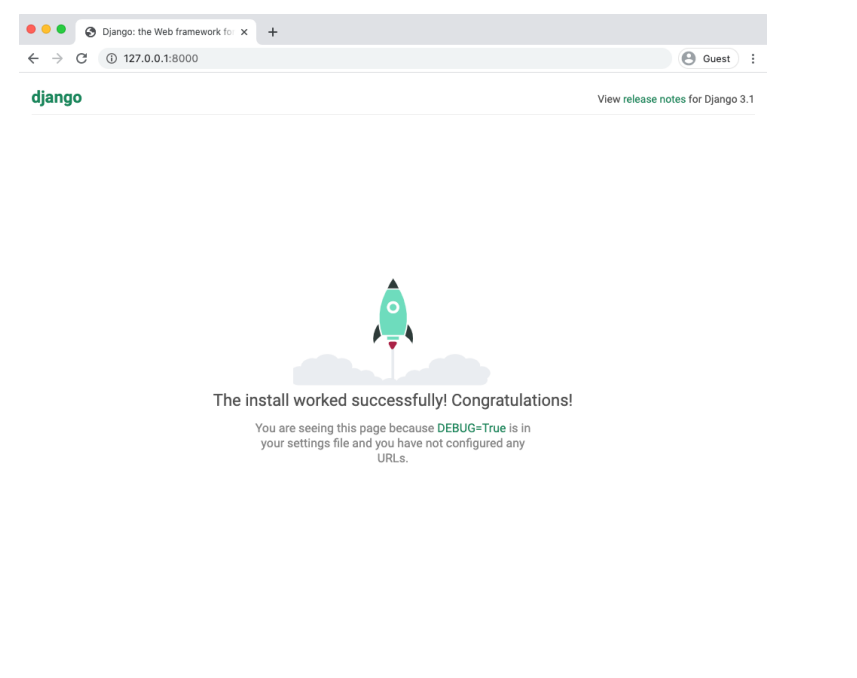

# **Custom User Model**

Creating our custom user model requires four steps:

• update config/settings.py

• create a new CustomUser model

• create new forms for UserCreationForm and UserChangeForm

• update accounts/admin.py

In config/settings.py we’ll add the accounts app to our INSTALLED_APPS. Then at the bottom
of the file use the AUTH_USER_MODEL config to tell Django to use our new custom user model in
place of the built-in User model. We’ll call our custom user model CustomUser so, since it exists
within our accounts app we refer to it as accounts.CustomUser.

In [ ]:
# config/settings.py
INSTALLED_APPS = [
   'django.contrib.admin',
   'django.contrib.auth',
   'django.contrib.contenttypes',
   'django.contrib.sessions',
   'django.contrib.messages',
   'django.contrib.staticfiles',
   'accounts', # new
]
...
AUTH_USER_MODEL = 'accounts.CustomUser' # new

Now update accounts/models.py with a new User model which we’ll call CustomUser that extends
the existing AbstractUser. We also include our first custom field, age, here.


In [ ]:
# accounts/models.py
from django.contrib.auth.models import AbstractUser
from django.db import models


class CustomUser(AbstractUser):
   age = models.PositiveIntegerField(null=True, blank=True)


If you read the official documentation on custom user models121 it recommends using AbstractBaseUser
not AbstractUser. This needlessly complicates things in my opinion, especially for beginners.


**AbstractBaseUser vs AbstractUser**

AbstractBaseUser requires a very fine level of control and customization. We essentially
rewrite Django. This can be helpful, but if we just want a custom user model that can be updated
with additional fields, the better choice is AbstractUser which subclasses AbstractBaseUser.
In other words, we write much less code and have less opportunity to mess things up. It’s the
better choice unless you really know what you’re doing with Django!

Note that we use both null122 and blank123 with our age field. These two terms are easy to confuse
but quite distinct:

• null is database-related. When a field has null=True it can store a database entry as NULL,
meaning no value.

• blank is validation-related, if blank=True then a form will allow an empty value, whereas
if blank=False then a value is required.

In practice, null and blank are commonly used together in this fashion so that a form allows an
empty value and the database stores that value as NULL.


A common gotcha to be aware of is that the field type dictates how to use these values. Whenever
you have a string-based field like CharField or TextField, setting both null and blank as we’ve
done will result in two possible values for “no data” in the database. Which is a bad idea. The
Django convention is instead to use the empty string '', not NULL.

# **Forms**

If we step back for a moment, what are the two ways in which we would interact with our
new CustomUser model? One case is when a user signs up for a new account on our website.

The other is within the admin app which allows us, as superusers, to modify existing users.
So we’ll need to update the two built-in forms for this functionality: UserCreationForm124 and
UserChangeForm125
.
Stop the local server with Control+c and create a new file in the accounts app called forms.py.


In [ ]:
(news) $ touch accounts/forms.py

We’ll update it with the following code to extend the existing UserCreationForm and UserChangeForm
forms.

In [ ]:
# accounts/forms.py
from django import forms
from django.contrib.auth.forms import UserCreationForm, UserChangeForm
from .models import CustomUser

class CustomUserCreationForm(UserCreationForm):

   class Meta(UserCreationForm):
       model = CustomUser
       fields = UserCreationForm.Meta.fields + ('age',)

class CustomUserChangeForm(UserChangeForm):
   class Meta:
       model = CustomUser
       fields = UserChangeForm.Meta.fields

For both new forms we are using the Meta class126 to override the default fields by setting the
model to our CustomUser and using the default fields via Meta.fields which includes all default
fields. To add our custom age field we simply tack it on at the end and it will display automatically
on our future sign up page. Pretty slick, no?

The concept of fields on a form can be confusing at first so let’s take a moment to explore it
further. Our CustomUser model contains all the fields of the default User model and our additional
age field which we set.

But what are these default fields? It turns out there are many127 including username, first_name,
last_name, email, password, groups, and more. Yet when a user signs up for a new account on
Django the default form only asks for a username, email, and password. This tells us that the
default setting for fields on UserCreationForm is just username, email, and password even though
there are many more fields available.

This might not click for you since understanding forms and models properly takes some time. In
the next chapter we will create our own sign up, log in, and log out pages which will tie together
our CustomUser model and forms more clearly. So hang tight!

The only other step we need is to update our admin.py file since Admin is tightly coupled to the
default User model. We will extend the existing UserAdmin128 class to use our new CustomUser
model.

In [ ]:
# accounts/admin.py
from django.contrib import admin
from django.contrib.auth.admin import UserAdmin
from .forms import CustomUserCreationForm, CustomUserChangeForm
from .models import CustomUser

class CustomUserAdmin(UserAdmin):
   add_form = CustomUserCreationForm
   form = CustomUserChangeForm
   model = CustomUser

admin.site.register(CustomUser, CustomUserAdmin)

Ok we’re done! Type Control+c to stop the local server and go ahead and run makemigrations
and migrate for the first time to create a new database that uses the custom user model.

In [ ]:
(news) $ python manage.py makemigrations accounts
Migrations for 'accounts':
accounts/migrations/0001_initial.py
- Create model CustomUser
(news) $ python manage.py migrate
Operations to perform:
Apply all migrations: admin, auth, contenttypes, sessions, users
Running migrations:
Applying contenttypes.0001_initial... OK
Applying contenttypes.0002_remove_content_type_name... OK
Applying auth.0001_initial... OK
Applying auth.0002_alter_permission_name_max_length... OK
Applying auth.0003_alter_user_email_max_length... OK
Applying auth.0004_alter_user_username_opts... OK
Applying auth.0005_alter_user_last_login_null... OK
Applying auth.0006_require_contenttypes_0002... OK
Applying auth.0007_alter_validators_add_error_messages... OK
Applying auth.0008_alter_user_username_max_length... OK
Applying auth.0009_alter_user_last_name_max_length... OK
Applying auth.0010_alter_group_name_max_length... OK
Applying auth.0011_update_proxy_permissions... OK
Applying auth.0012_alter_user_first_name_max_length... OK
Applying accounts.0001_initial... OK
Applying admin.0001_initial... OK
Applying admin.0002_logentry_remove_auto_add... OK
Applying admin.0003_logentry_add_action_flag_choices... OK
Applying sessions.0001_initial... OK


# **Superuser**

Let’s create a superuser account to confirm that everything is working as expected.
On the command line type the following command and go through the prompts.

In [ ]:
(news) $ python manage.py createsuperuser

The fact that this works is the first proof our custom user model works as expected. Let’s view
things in the admin too to be extra sure.
Start up the web server.

In [ ]:
(news) $ python manage.py runserver

Then navigate to the admin at http://127.0.0.1:8000/admin and log in. If you click on the link
for “Users,” you should see your superuser account as well as the default fields of Username,
Email Address, First Name, Last Name, and Staff Status.


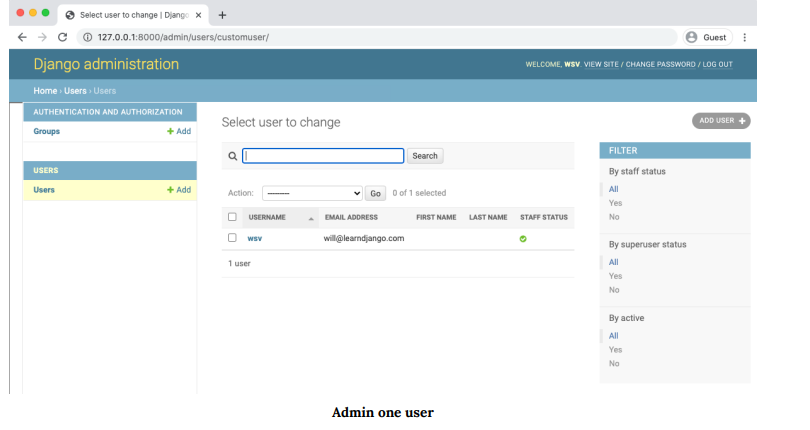

To control the fields listed here we use list_display129. However, to actually edit and add new
custom fields, like age, we must also add fieldsets1

In [ ]:
# accounts/admin.py
from django.contrib import admin
from django.contrib.auth.admin import UserAdmin

from .forms import CustomUserCreationForm, CustomUserChangeForm
from .models import CustomUser

class CustomUserAdmin(UserAdmin):
   add_form = CustomUserCreationForm
   form = CustomUserChangeForm
   model = CustomUser
   list_display = ['email', 'username', 'age', 'is_staff', ] # new
   fieldsets = UserAdmin.fieldsets + ( # new
       (None, {'fields': ('age',)}),
   )
   add_fieldsets = UserAdmin.add_fieldsets + ( # new
      (None, {'fields': ('age',)}),
   )

admin.site.register(CustomUser, CustomUserAdmin)



Refresh the page and you should see the update.

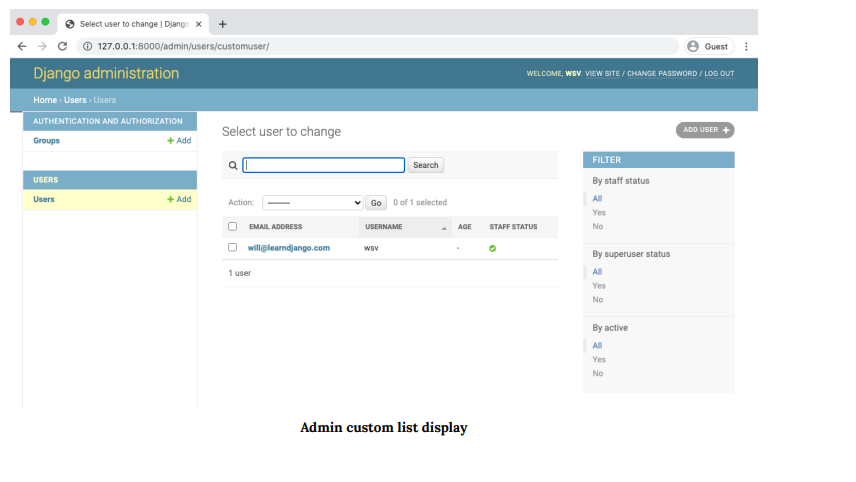

# **Conclusion**

With our custom user model complete, we can now focus on building out the rest of our
Newspaper website. In the next chapter we will configure and customize sign up, log in, and
log out pages.
